In [21]:
# open FlatVelA/data/data1.npy
import numpy as np
data = np.load('OpenFWI/FlatVelA/data/data1.npy')
velocity = np.load('OpenFWI/FlatVelA/model/model1.npy')
# print the shape of the data
print(data.shape)
# plot sample 14 imshow 

(500, 5, 1000, 70)


In [9]:
import matplotlib.pyplot as plt
## Select a sample in the data
sample=14

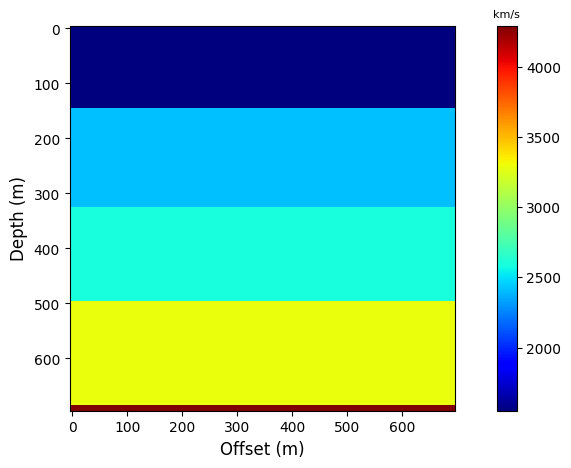

In [14]:
from matplotlib.colors import ListedColormap
fig, ax = plt.subplots(1, 1, figsize=(11, 5))
img=ax.imshow(velocity[sample,0,:,:],cmap='jet')
ax.set_xticks(range(0, 70, 10))
ax.set_xticklabels(range(0, 700, 100))
ax.set_yticks(range(0, 70, 10))
ax.set_yticklabels(range(0, 700, 100))
ax.set_ylabel('Depth (m)', fontsize=12)
ax.set_xlabel('Offset (m)', fontsize=12)
clb=plt.colorbar(img, ax=ax)
clb.ax.set_title('km/s',fontsize=8)
plt.show()

In [18]:
import pywt
import numpy as np

# Assume `vel_map` is a 2D NumPy array representing the velocity model
wavelet = 'haar'  # Haar wavelet (good for piecewise constant signals)
level = 3         # Decomposition level (e.g., 3 levels)

# Perform multilevel 2D wavelet decomposition
coeffs = pywt.wavedec2(velocity[sample,0,:,:], wavelet=wavelet, level=level)
cA, *detail_coeffs = coeffs  # cA is approximation, detail_coeffs = [(cH, cV, cD), ...]

# Threshold small coefficients in detail sub-bands to denoise (soft threshold)
threshold = 0.05 * np.max([np.max(abs(c)) for band in detail_coeffs for c in band])
detail_coeffs_thresh = []
for (cH, cV, cD) in detail_coeffs:
    cH_t = pywt.threshold(cH, threshold, mode='soft')
    cV_t = pywt.threshold(cV, threshold, mode='soft')
    cD_t = pywt.threshold(cD, threshold, mode='soft')
    detail_coeffs_thresh.append((cH_t, cV_t, cD_t))

# Reconstruct image from thresholded coefficients
coeffs_thresh = [cA] + detail_coeffs_thresh
vel_denoised = pywt.waverec2(coeffs_thresh, wavelet=wavelet)
vel_denoised = pywt.waverec2(coeffs_thresh, wavelet=wavelet)

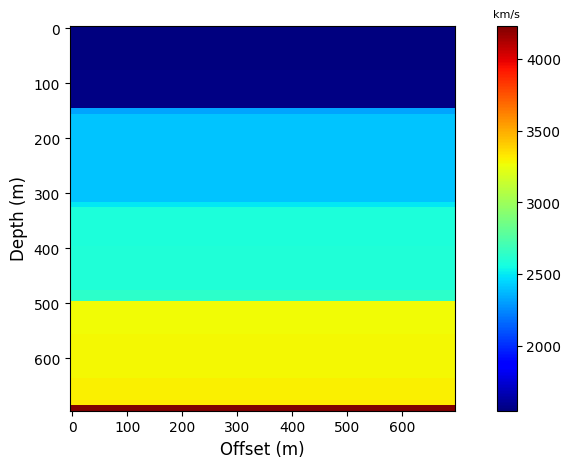

In [19]:
# plot denoised image
fig, ax = plt.subplots(1, 1, figsize=(11, 5))
img=ax.imshow(vel_denoised, cmap='jet')
ax.set_xticks(range(0, 70, 10))
ax.set_xticklabels(range(0, 700, 100))
ax.set_yticks(range(0, 70, 10))
ax.set_yticklabels(range(0, 700, 100))
ax.set_ylabel('Depth (m)', fontsize=12)
ax.set_xlabel('Offset (m)', fontsize=12)
clb=plt.colorbar(img, ax=ax)
clb.ax.set_title('km/s', fontsize=8)
plt.show()

In [ ]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

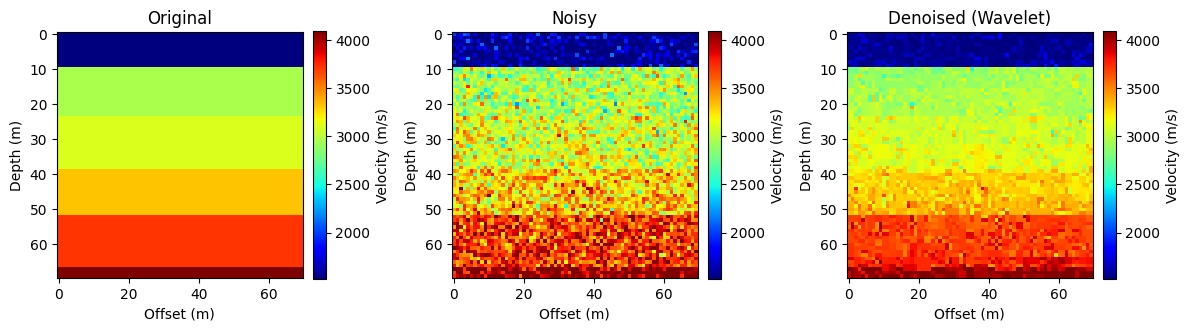

Wavelet Thresholding -> MSE: 11621.202489, PSNR: 27.53 dB, SSIM: 0.5402


In [22]:
import numpy as np
import pywt
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# Load velocity data (shape: 500 x 1 x 70 x 70)
velocity = np.load('OpenFWI/FlatVelA/model/model1.npy')
sample_index = 0
clean_map = velocity[sample_index, 0].astype(np.float32)

# Add Gaussian noise to the clean map
noise_std = 0.1 * (clean_map.max() - clean_map.min())  # e.g., 10% of dynamic range
np.random.seed(0)
noisy_map = clean_map + noise_std * np.random.randn(*clean_map.shape)

# Wavelet decomposition (Haar wavelet)
wavelet = 'haar'
coeffs = pywt.wavedec2(noisy_map, wavelet=wavelet, mode='periodization')
# Determine threshold (e.g., universal threshold or scaled noise level)
threshold = noise_std  # simple choice: equal to noise std (adjust as needed)
# Apply soft thresholding to detail coeffs (skip the approximation coeff at index 0)
coeffs_thresh = [coeffs[0]]  # keep approximation coefficients unmodified
for detail_level in coeffs[1:]:
    cH, cV, cD = detail_level
    cH_t = pywt.threshold(cH, value=threshold, mode='soft')
    cV_t = pywt.threshold(cV, value=threshold, mode='soft')
    cD_t = pywt.threshold(cD, value=threshold, mode='soft')
    coeffs_thresh.append((cH_t, cV_t, cD_t))

# Reconstruct the denoised image from thresholded coefficients
denoised_map = pywt.waverec2(coeffs_thresh, wavelet=wavelet, mode='periodization')

# Compute error metrics
mse = np.mean((denoised_map - clean_map) ** 2)
psnr = peak_signal_noise_ratio(clean_map, denoised_map, data_range=clean_map.max()-clean_map.min())
ssim_val = structural_similarity(clean_map, denoised_map, data_range=clean_map.max()-clean_map.min())

# Plot original, noisy, and denoised images
import matplotlib.pyplot as plt
vmin, vmax = clean_map.min(), clean_map.max()
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
# Original
im0 = axs[0].imshow(clean_map, cmap='jet', vmin=vmin, vmax=vmax)
axs[0].set_title("Original")
axs[0].set_xlabel("Offset (m)"); axs[0].set_ylabel("Depth (m)")
plt.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04, label='Velocity (m/s)')
# Noisy
im1 = axs[1].imshow(noisy_map, cmap='jet', vmin=vmin, vmax=vmax)
axs[1].set_title("Noisy")
axs[1].set_xlabel("Offset (m)"); axs[1].set_ylabel("Depth (m)")
plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04, label='Velocity (m/s)')
# Denoised (Wavelet)
im2 = axs[2].imshow(denoised_map, cmap='jet', vmin=vmin, vmax=vmax)
axs[2].set_title("Denoised (Wavelet)")
axs[2].set_xlabel("Offset (m)"); axs[2].set_ylabel("Depth (m)")
plt.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04, label='Velocity (m/s)')
plt.tight_layout()
plt.show()

print(f"Wavelet Thresholding -> MSE: {mse:.6f}, PSNR: {psnr:.2f} dB, SSIM: {ssim_val:.4f}")

In [58]:
# print the original velocity map data
print("Original Velocity Map Data (Sample 0):")
print(clean_map)
print("Noisy Velocity Map Data (Sample 0):")
print(noisy_map)

Original Velocity Map Data (Sample 0):
[[1524. 1524. 1524. ... 1524. 1524. 1524.]
 [1524. 1524. 1524. ... 1524. 1524. 1524.]
 [1524. 1524. 1524. ... 1524. 1524. 1524.]
 ...
 [4088. 4088. 4088. ... 4088. 4088. 4088.]
 [4088. 4088. 4088. ... 4088. 4088. 4088.]
 [4088. 4088. 4088. ... 4088. 4088. 4088.]]
Noisy Velocity Map Data (Sample 0):
[[1976.30301074 1626.60030578 1774.94841315 ... 1642.65736749
  1291.36870491 1537.31879917]
 [1710.93881569 1557.07121753 1816.14232856 ... 1470.59220034
  1625.53611871 1243.73903583]
 [1141.64156233 1636.66002952 1566.7350832  ... 1334.76887938
  1595.77266549 1498.83424069]
 ...
 [4271.52688073 4128.68235858 4045.02477677 ... 4223.29727113
  4030.91991053 3961.98324387]
 [3679.33955974 4349.11085561 4100.73928906 ... 3978.71711444
  4002.09271237 4049.97778562]
 [3740.68451206 3925.22591834 4053.16240287 ... 4496.29794164
  4077.37409674 4440.79141252]]


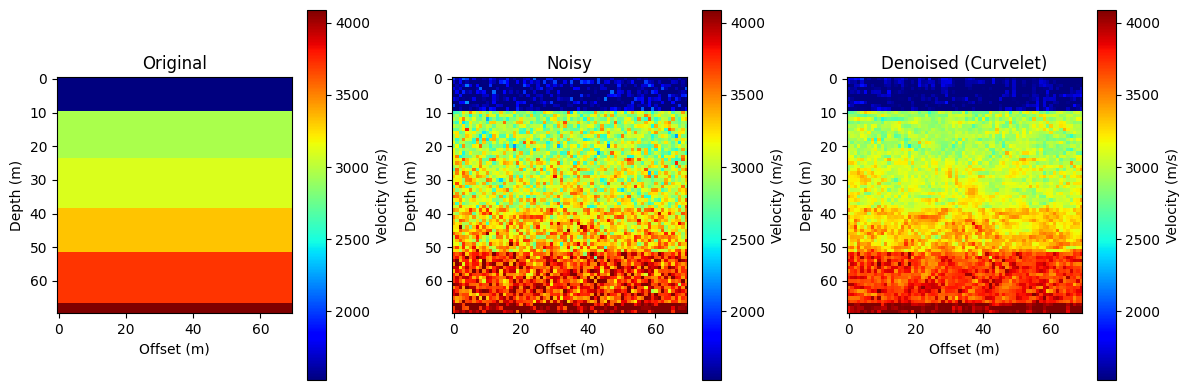

Curvelet Thresholding -> MSE: 19387.042394, PSNR: 25.30 dB, SSIM: 0.4434


In [27]:
import numpy as np
from curvelets.numpy import SimpleUDCT
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import matplotlib.pyplot as plt

# Prepare the clean and noisy image
sample_index = 0
clean_map = velocity[sample_index, 0].astype(np.float32)
noise_std = 0.1 * (clean_map.max() - clean_map.min())
np.random.seed(0)
noisy_map = clean_map + noise_std * np.random.randn(*clean_map.shape)

# Pad image to next power-of-2 size for curvelet transform
rows, cols = clean_map.shape
new_size = 1
while new_size < max(rows, cols):
    new_size *= 2
pad_y_top = (new_size - rows) // 2
pad_y_bottom = new_size - rows - pad_y_top
pad_x_left = (new_size - cols) // 2
pad_x_right = new_size - cols - pad_x_left
noisy_pad = np.pad(noisy_map, ((pad_y_top, pad_y_bottom), (pad_x_left, pad_x_right)), mode='edge')

# Curvelet transform (forward)
udct = SimpleUDCT(noisy_pad.shape)
coeffs = udct.forward(noisy_pad)

# Thresholding small coefficients (nested thresholding)
threshold = noise_std
coeffs_thresh = [
    [np.where(np.abs(c) < threshold, 0, c) for c in scale]
    for scale in coeffs
]

# Inverse curvelet transform (reconstruction)
denoised_pad = udct.backward(coeffs_thresh)
denoised_map = denoised_pad[pad_y_top:pad_y_top+rows, pad_x_left:pad_x_left+cols]

# Compute error metrics
mse = np.mean((denoised_map - clean_map) ** 2)
psnr = peak_signal_noise_ratio(clean_map, denoised_map, data_range=clean_map.max()-clean_map.min())
ssim_val = structural_similarity(clean_map, denoised_map, data_range=clean_map.max()-clean_map.min())

# Plot results
vmin, vmax = clean_map.min(), clean_map.max()
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
im0 = axs[0].imshow(clean_map, cmap='jet', vmin=vmin, vmax=vmax); axs[0].set_title("Original")
axs[0].set_xlabel("Offset (m)"); axs[0].set_ylabel("Depth (m)"); plt.colorbar(im0, ax=axs[0], label='Velocity (m/s)')
im1 = axs[1].imshow(noisy_map, cmap='jet', vmin=vmin, vmax=vmax); axs[1].set_title("Noisy")
axs[1].set_xlabel("Offset (m)"); axs[1].set_ylabel("Depth (m)"); plt.colorbar(im1, ax=axs[1], label='Velocity (m/s)')
im2 = axs[2].imshow(denoised_map, cmap='jet', vmin=vmin, vmax=vmax); axs[2].set_title("Denoised (Curvelet)")
axs[2].set_xlabel("Offset (m)"); axs[2].set_ylabel("Depth (m)"); plt.colorbar(im2, ax=axs[2], label='Velocity (m/s)')
plt.tight_layout(); plt.show()

print(f"Curvelet Thresholding -> MSE: {mse:.6f}, PSNR: {psnr:.2f} dB, SSIM: {ssim_val:.4f}")

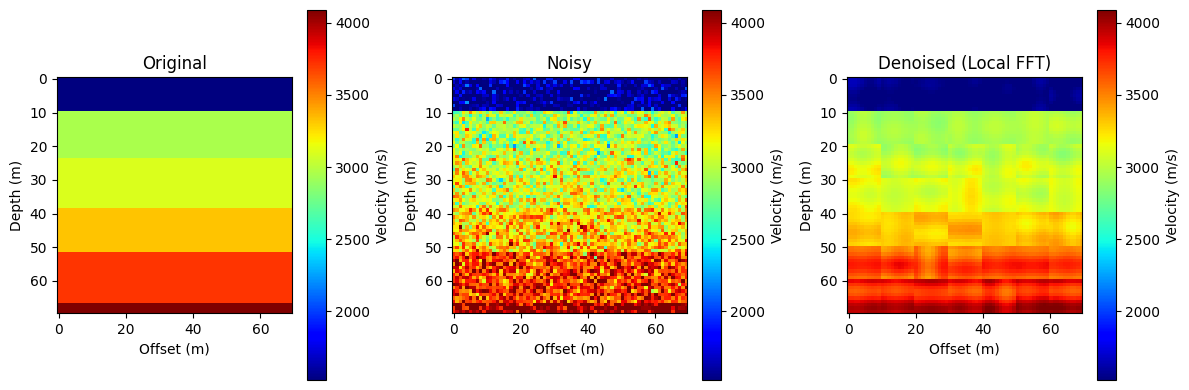

Local Fourier Filtering (STFT) -> MSE: 7426.753715, PSNR: 29.47 dB, SSIM: 0.6825


In [28]:
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# Prepare the clean and noisy image
sample_index = 0
clean_map = velocity[sample_index, 0].astype(np.float32)
noise_std = 0.1 * (clean_map.max() - clean_map.min())
np.random.seed(0)
noisy_map = clean_map + noise_std * np.random.randn(*clean_map.shape)

# Patch-wise local Fourier filtering
patch_size = 10  # size of each square patch
denoised_map = np.zeros_like(noisy_map)
# Loop over non-overlapping patches
for i in range(0, clean_map.shape[0], patch_size):
    for j in range(0, clean_map.shape[1], patch_size):
        patch = noisy_map[i:i+patch_size, j:j+patch_size]
        # Compute 2D FFT of the patch
        F = np.fft.fft2(patch)
        F_shift = np.fft.fftshift(F)
        # Create a low-pass circular mask in the patch's frequency domain
        rows, cols = patch.shape
        crow, ccol = rows // 2, cols // 2
        r = 1  # radius of low-frequency pass (in frequency pixels)
        mask = np.zeros((rows, cols), dtype=float)
        for u in range(rows):
            for v in range(cols):
                if (u - crow)**2 + (v - ccol)**2 <= r*r:
                    mask[u, v] = 1.0
        # Apply mask and inverse FFT
        F_shift_filtered = F_shift * mask
        F_filtered = np.fft.ifftshift(F_shift_filtered)
        patch_denoised = np.fft.ifft2(F_filtered).real
        # Put the filtered patch back into the output image
        denoised_map[i:i+patch_size, j:j+patch_size] = patch_denoised

# Compute error metrics
mse = np.mean((denoised_map - clean_map) ** 2)
psnr = peak_signal_noise_ratio(clean_map, denoised_map, data_range=clean_map.max()-clean_map.min())
ssim_val = structural_similarity(clean_map, denoised_map, data_range=clean_map.max()-clean_map.min())

# Plot original, noisy, and denoised images
import matplotlib.pyplot as plt
vmin, vmax = clean_map.min(), clean_map.max()
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
im0 = axs[0].imshow(clean_map, cmap='jet', vmin=vmin, vmax=vmax); axs[0].set_title("Original")
axs[0].set_xlabel("Offset (m)"); axs[0].set_ylabel("Depth (m)"); plt.colorbar(im0, ax=axs[0], label='Velocity (m/s)')
im1 = axs[1].imshow(noisy_map, cmap='jet', vmin=vmin, vmax=vmax); axs[1].set_title("Noisy")
axs[1].set_xlabel("Offset (m)"); axs[1].set_ylabel("Depth (m)"); plt.colorbar(im1, ax=axs[1], label='Velocity (m/s)')
im2 = axs[2].imshow(denoised_map, cmap='jet', vmin=vmin, vmax=vmax); axs[2].set_title("Denoised (Local FFT)")
axs[2].set_xlabel("Offset (m)"); axs[2].set_ylabel("Depth (m)"); plt.colorbar(im2, ax=axs[2], label='Velocity (m/s)')
plt.tight_layout(); plt.show()

print(f"Local Fourier Filtering (STFT) -> MSE: {mse:.6f}, PSNR: {psnr:.2f} dB, SSIM: {ssim_val:.4f}")

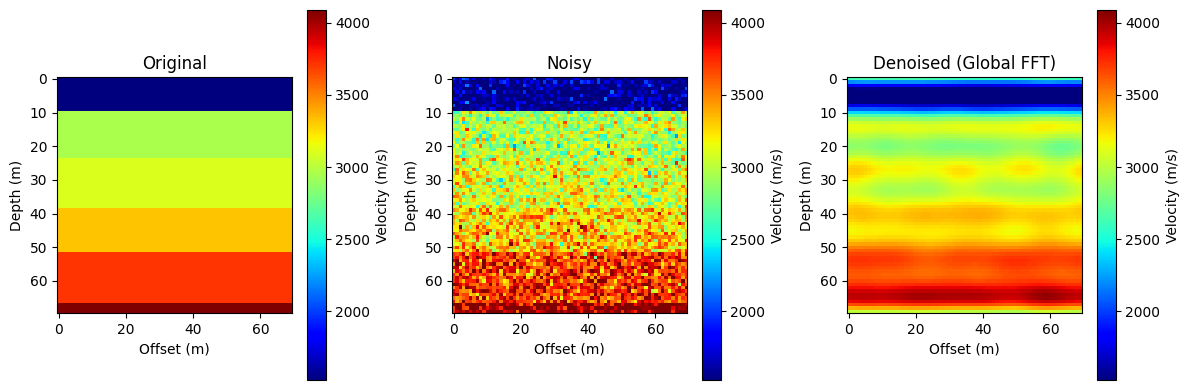

Global DFT Low-pass -> MSE: 73883.805022, PSNR: 19.49 dB, SSIM: 0.5217


In [29]:
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# Prepare the clean and noisy image
sample_index = 0
clean_map = velocity[sample_index, 0].astype(np.float32)
noise_std = 0.1 * (clean_map.max() - clean_map.min())
np.random.seed(0)
noisy_map = clean_map + noise_std * np.random.randn(*clean_map.shape)

# Global 2D FFT of the noisy image
F = np.fft.fft2(noisy_map)
F_shift = np.fft.fftshift(F)
# Create a low-pass mask (keep frequencies within a radius r of the center)
rows, cols = noisy_map.shape
crow, ccol = rows // 2, cols // 2
r = 5  # low-pass radius in frequency domain (tune this parameter)
mask = np.zeros((rows, cols), dtype=float)
for u in range(rows):
    for v in range(cols):
        if (u - crow)**2 + (v - ccol)**2 <= r*r:
            mask[u, v] = 1.0
# Apply mask and inverse FFT to get filtered image
F_shift_filtered = F_shift * mask
F_filtered = np.fft.ifftshift(F_shift_filtered)
denoised_map = np.fft.ifft2(F_filtered).real

# Compute error metrics
mse = np.mean((denoised_map - clean_map) ** 2)
psnr = peak_signal_noise_ratio(clean_map, denoised_map, data_range=clean_map.max()-clean_map.min())
ssim_val = structural_similarity(clean_map, denoised_map, data_range=clean_map.max()-clean_map.min())

# Plot original, noisy, and denoised images
import matplotlib.pyplot as plt
vmin, vmax = clean_map.min(), clean_map.max()
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
im0 = axs[0].imshow(clean_map, cmap='jet', vmin=vmin, vmax=vmax); axs[0].set_title("Original")
axs[0].set_xlabel("Offset (m)"); axs[0].set_ylabel("Depth (m)"); plt.colorbar(im0, ax=axs[0], label='Velocity (m/s)')
im1 = axs[1].imshow(noisy_map, cmap='jet', vmin=vmin, vmax=vmax); axs[1].set_title("Noisy")
axs[1].set_xlabel("Offset (m)"); axs[1].set_ylabel("Depth (m)"); plt.colorbar(im1, ax=axs[1], label='Velocity (m/s)')
im2 = axs[2].imshow(denoised_map, cmap='jet', vmin=vmin, vmax=vmax); axs[2].set_title("Denoised (Global FFT)")
axs[2].set_xlabel("Offset (m)"); axs[2].set_ylabel("Depth (m)"); plt.colorbar(im2, ax=axs[2], label='Velocity (m/s)')
plt.tight_layout(); plt.show()

print(f"Global DFT Low-pass -> MSE: {mse:.6f}, PSNR: {psnr:.2f} dB, SSIM: {ssim_val:.4f}")

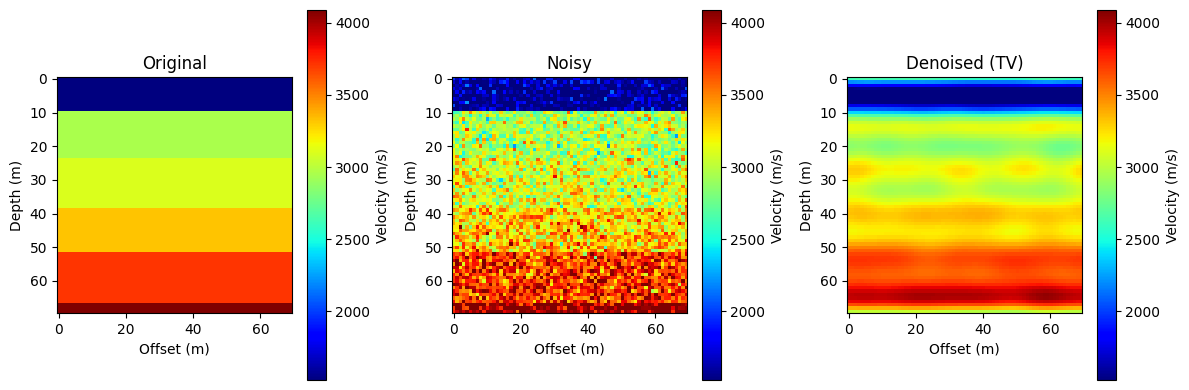

TV Denoising -> MSE: 73883.805022, PSNR: 19.49 dB, SSIM: 0.5217


In [31]:
import numpy as np
from skimage.restoration import denoise_tv_chambolle
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# Prepare the clean and noisy image
sample_index = 0
clean_map = velocity[sample_index, 0].astype(np.float32)
noise_std = 0.1 * (clean_map.max() - clean_map.min())
np.random.seed(0)
noisy_map = clean_map + noise_std * np.random.randn(*clean_map.shape)

# Total Variation denoising using Chambolle’s method
denoise_tv_chambolle(noisy_map, weight=0.1, channel_axis=None)  # adjust weight as needed

# Compute error metrics
mse = np.mean((denoised_map - clean_map) ** 2)
psnr = peak_signal_noise_ratio(clean_map, denoised_map, data_range=clean_map.max()-clean_map.min())
ssim_val = structural_similarity(clean_map, denoised_map, data_range=clean_map.max()-clean_map.min())

# Plot original, noisy, and denoised images
import matplotlib.pyplot as plt
vmin, vmax = clean_map.min(), clean_map.max()
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
im0 = axs[0].imshow(clean_map, cmap='jet', vmin=vmin, vmax=vmax); axs[0].set_title("Original")
axs[0].set_xlabel("Offset (m)"); axs[0].set_ylabel("Depth (m)"); plt.colorbar(im0, ax=axs[0], label='Velocity (m/s)')
im1 = axs[1].imshow(noisy_map, cmap='jet', vmin=vmin, vmax=vmax); axs[1].set_title("Noisy")
axs[1].set_xlabel("Offset (m)"); axs[1].set_ylabel("Depth (m)"); plt.colorbar(im1, ax=axs[1], label='Velocity (m/s)')
im2 = axs[2].imshow(denoised_map, cmap='jet', vmin=vmin, vmax=vmax); axs[2].set_title("Denoised (TV)")
axs[2].set_xlabel("Offset (m)"); axs[2].set_ylabel("Depth (m)"); plt.colorbar(im2, ax=axs[2], label='Velocity (m/s)')
plt.tight_layout(); plt.show()

print(f"TV Denoising -> MSE: {mse:.6f}, PSNR: {psnr:.2f} dB, SSIM: {ssim_val:.4f}")

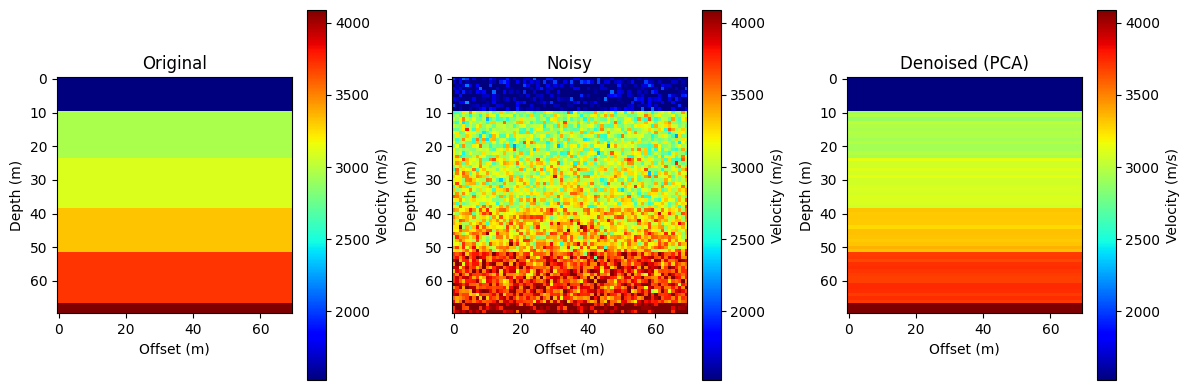

PCA Denoising -> MSE: 680.722778, PSNR: 39.85 dB, SSIM: 0.9444


In [56]:
import numpy as np
from sklearn.decomposition import PCA
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# Prepare training data for PCA (e.g., use first 100 clean velocity maps)
X_train = velocity[:100, 0].reshape(100, -1).astype(np.float32)  # shape: (100, 4900)
# Normalize training data (optional): subtract mean
X_mean = X_train.mean(axis=0)
X_train_centered = X_train - X_mean
# Fit PCA on training set
pca = PCA(n_components=50)  # keep 50 principal components (adjust for desired fidelity)
pca.fit(X_train_centered)

# Select a sample and add noise
sample_index = 0
clean_map = velocity[sample_index, 0].astype(np.float32)
noise_std = 0.1 * (clean_map.max() - clean_map.min())
np.random.seed(0)
noisy_map = clean_map + noise_std * np.random.randn(*clean_map.shape)

# PCA denoising: project noisy image onto PCA space and reconstruct
noisy_flat = noisy_map.flatten().astype(np.float32)
noisy_flat_centered = noisy_flat - X_mean  # center using training mean
coef = pca.transform(noisy_flat_centered.reshape(1, -1))  # PCA coefficients (1 x n_components)
recon_flat = pca.inverse_transform(coef)  # reconstruct in centered space
recon_flat = recon_flat.reshape(-1) + X_mean  # add back mean
denoised_map = recon_flat.reshape(clean_map.shape)

# Compute error metrics
mse = np.mean((denoised_map - clean_map) ** 2)
psnr = peak_signal_noise_ratio(clean_map, denoised_map, data_range=clean_map.max()-clean_map.min())
ssim_val = structural_similarity(clean_map, denoised_map, data_range=clean_map.max()-clean_map.min())

# Plot original, noisy, and denoised images
import matplotlib.pyplot as plt
vmin, vmax = clean_map.min(), clean_map.max()
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
im0 = axs[0].imshow(clean_map, cmap='jet', vmin=vmin, vmax=vmax); axs[0].set_title("Original")
axs[0].set_xlabel("Offset (m)"); axs[0].set_ylabel("Depth (m)"); plt.colorbar(im0, ax=axs[0], label='Velocity (m/s)')
im1 = axs[1].imshow(noisy_map, cmap='jet', vmin=vmin, vmax=vmax); axs[1].set_title("Noisy")
axs[1].set_xlabel("Offset (m)"); axs[1].set_ylabel("Depth (m)"); plt.colorbar(im1, ax=axs[1], label='Velocity (m/s)')
im2 = axs[2].imshow(denoised_map, cmap='jet', vmin=vmin, vmax=vmax); axs[2].set_title("Denoised (PCA)")
axs[2].set_xlabel("Offset (m)"); axs[2].set_ylabel("Depth (m)"); plt.colorbar(im2, ax=axs[2], label='Velocity (m/s)')
plt.tight_layout(); plt.show()

print(f"PCA Denoising -> MSE: {mse:.6f}, PSNR: {psnr:.2f} dB, SSIM: {ssim_val:.4f}")

/Users/smorales/miniconda3/envs/openfwi/lib/python3.10/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.060e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/Users/smorales/miniconda3/envs/openfwi/lib/python3.10/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=6.539e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/Users/smorales/miniconda3/envs/openfwi/lib/python3.10/site-packages/sklearn/linear_model/_least_angle.py:753: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no long

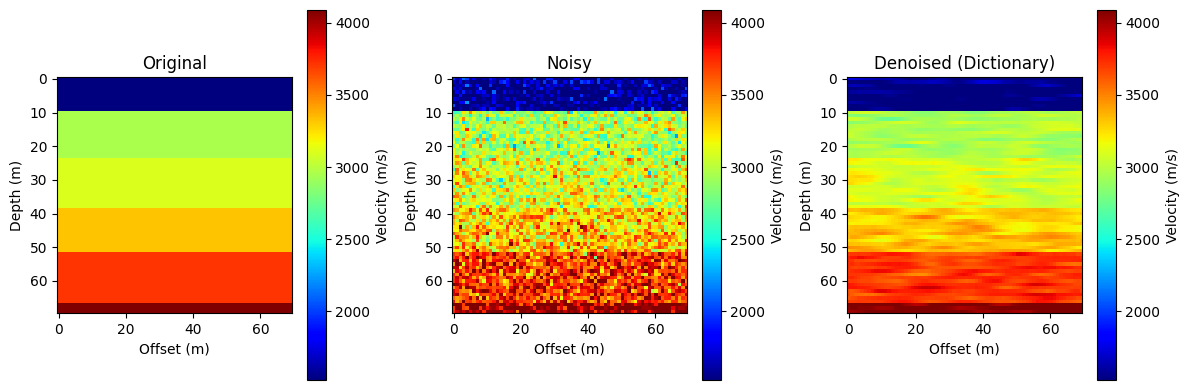

Dictionary Learning Denoising -> MSE: 5632.707501, PSNR: 30.67 dB, SSIM: 0.7066


In [34]:
import numpy as np
from sklearn.feature_extraction.image import extract_patches_2d, reconstruct_from_patches_2d
from sklearn.decomposition import MiniBatchDictionaryLearning
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# Prepare training patches from multiple clean velocity maps
patch_size = (7, 7)
num_train_images = 100
patches_per_image = 100
np.random.seed(0)
patch_list = []
for i in range(num_train_images):
    img = velocity[i, 0].astype(np.float32)
    patches = extract_patches_2d(img, patch_size, max_patches=patches_per_image, random_state=0)
    # Flatten patches to 1D vectors
    patches = patches.reshape(patches.shape[0], -1)
    patch_list.append(patches)
training_patches = np.vstack(patch_list)  # shape: (num_train_images*patches_per_image, patch_size[0]*patch_size[1])
# Normalize patches for training (zero-mean, unit-std)
patch_mean = training_patches.mean(axis=0)
patch_std = training_patches.std(axis=0) + 1e-8
training_patches_norm = (training_patches - patch_mean) / patch_std

# Learn dictionary of patch atoms using sparse coding
dico = MiniBatchDictionaryLearning(n_components=100, alpha=1.0, max_iter=500, batch_size=256, random_state=0)
dico.fit(training_patches_norm)
dictionary = dico.components_  # shape: (100, 49) for 7x7 patches

# Denoise a sample image using the learned dictionary
sample_index = 0
clean_map = velocity[sample_index, 0].astype(np.float32)
noise_std = 0.1 * (clean_map.max() - clean_map.min())
np.random.seed(0)
noisy_map = clean_map + noise_std * np.random.randn(*clean_map.shape)

# Extract overlapping patches from the noisy image
noisy_patches = extract_patches_2d(noisy_map, patch_size)
orig_shape = noisy_map.shape
noisy_patches_flat = noisy_patches.reshape(noisy_patches.shape[0], -1)
# Normalize patches using training mean and std
noisy_patches_norm = (noisy_patches_flat - patch_mean) / patch_std
# Sparse encode the noisy patches with the trained dictionary
code = dico.transform(noisy_patches_norm)   # sparse codes for each patch
# Reconstruct patches from sparse codes
recon_patches_flat = code.dot(dictionary)   # multiply codes by dictionary atoms
# Denormalize reconstructed patches
recon_patches_flat = recon_patches_flat * patch_std + patch_mean
recon_patches = recon_patches_flat.reshape(-1, patch_size[0], patch_size[1])
# Reconstruct the denoised image from patches
denoised_map = reconstruct_from_patches_2d(recon_patches, orig_shape)

# Compute error metrics
mse = np.mean((denoised_map - clean_map) ** 2)
psnr = peak_signal_noise_ratio(clean_map, denoised_map, data_range=clean_map.max()-clean_map.min())
ssim_val = structural_similarity(clean_map, denoised_map, data_range=clean_map.max()-clean_map.min())

# Plot original, noisy, and denoised images
import matplotlib.pyplot as plt
vmin, vmax = clean_map.min(), clean_map.max()
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
im0 = axs[0].imshow(clean_map, cmap='jet', vmin=vmin, vmax=vmax); axs[0].set_title("Original")
axs[0].set_xlabel("Offset (m)"); axs[0].set_ylabel("Depth (m)"); plt.colorbar(im0, ax=axs[0], label='Velocity (m/s)')
im1 = axs[1].imshow(noisy_map, cmap='jet', vmin=vmin, vmax=vmax); axs[1].set_title("Noisy")
axs[1].set_xlabel("Offset (m)"); axs[1].set_ylabel("Depth (m)"); plt.colorbar(im1, ax=axs[1], label='Velocity (m/s)')
im2 = axs[2].imshow(denoised_map, cmap='jet', vmin=vmin, vmax=vmax); axs[2].set_title("Denoised (Dictionary)")
axs[2].set_xlabel("Offset (m)"); axs[2].set_ylabel("Depth (m)"); plt.colorbar(im2, ax=axs[2], label='Velocity (m/s)')
plt.tight_layout(); plt.show()

print(f"Dictionary Learning Denoising -> MSE: {mse:.6f}, PSNR: {psnr:.2f} dB, SSIM: {ssim_val:.4f}")

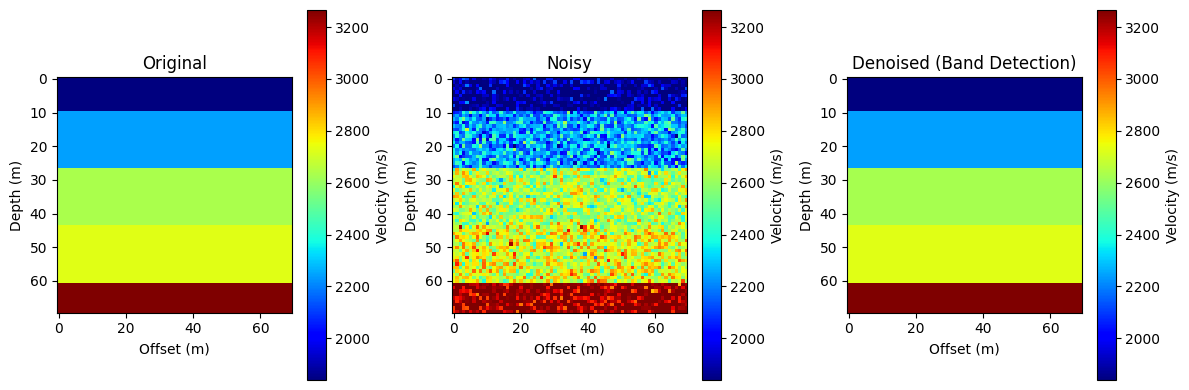

Band Detection Denoising -> MSE: 33.853783, PSNR: 47.79 dB, SSIM: 0.9999
Predicted number of bands: 5
Average MSE: 159.399907
Average PSNR: 47.08 dB
Average SSIM: 0.9948


In [114]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# Function to apply the band detection + reconstruction method
def band_denoising(clean_map, noise_std, window=5):
    # Add noise
    np.random.seed(0)
    noisy_map = clean_map + noise_std * np.random.randn(*clean_map.shape)

    # Vertical profile smoothing
    row_mean = noisy_map.mean(axis=1)
    pad = window // 2
    padded = np.pad(row_mean, pad, mode='edge')
    smoothed_profile = np.array([np.median(padded[i:i+window]) for i in range(len(row_mean))])

    # Detect band boundaries
    diff = np.diff(smoothed_profile)
    threshold = noise_std / 5
    boundary_indices = np.where(np.abs(diff) > threshold)[0]

    # Band segmentation
    band_bounds = []
    current_start = 0
    for idx in boundary_indices:
        band_bounds.append((current_start, idx))
        current_start = idx + 1
    band_bounds.append((current_start, len(row_mean) - 1))

    # Bandwise averaging
    band_velocities = []
    for (i, j) in band_bounds:
        band_val = noisy_map[i:j+1, :].mean()
        band_velocities.append(band_val)

    # Reconstruct denoised map
    recon_map = np.zeros_like(noisy_map)
    for (i, j), val in zip(band_bounds, band_velocities):
        recon_map[i:j+1, :] = val

    return noisy_map, recon_map, len(band_bounds)

# Now apply to a real velocity map
sample_index = 100
clean_map = velocity[sample_index, 0].astype(np.float32)
noise_std = 0.1 * (clean_map.max() - clean_map.min())

noisy_map, denoised_map, num_bands = band_denoising(clean_map, noise_std)

# Compute error metrics
mse = np.mean((denoised_map - clean_map) ** 2)
psnr = peak_signal_noise_ratio(clean_map, denoised_map, data_range=clean_map.max()-clean_map.min())
ssim_val = structural_similarity(clean_map, denoised_map, data_range=clean_map.max()-clean_map.min())

# Plot original, noisy, and denoised images
vmin, vmax = clean_map.min(), clean_map.max()
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
im0 = axs[0].imshow(clean_map, cmap='jet', vmin=vmin, vmax=vmax); axs[0].set_title("Original")
axs[0].set_xlabel("Offset (m)"); axs[0].set_ylabel("Depth (m)"); plt.colorbar(im0, ax=axs[0], label='Velocity (m/s)')
im1 = axs[1].imshow(noisy_map, cmap='jet', vmin=vmin, vmax=vmax); axs[1].set_title("Noisy")
axs[1].set_xlabel("Offset (m)"); axs[1].set_ylabel("Depth (m)"); plt.colorbar(im1, ax=axs[1], label='Velocity (m/s)')
im2 = axs[2].imshow(denoised_map, cmap='jet', vmin=vmin, vmax=vmax); axs[2].set_title("Denoised (Band Detection)")
axs[2].set_xlabel("Offset (m)"); axs[2].set_ylabel("Depth (m)"); plt.colorbar(im2, ax=axs[2], label='Velocity (m/s)')
plt.tight_layout(); plt.show()

# Print evaluation metrics
print(f"Band Detection Denoising -> MSE: {mse:.6f}, PSNR: {psnr:.2f} dB, SSIM: {ssim_val:.4f}")
print(f"Predicted number of bands: {num_bands}")

# print the statistics of applying the procedure to every velocity map
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
# Initialize lists to store metrics
mse_list = []
psnr_list = []
ssim_list = []
# Loop through all velocity maps
for sample_index in range(velocity.shape[0]):
    clean_map = velocity[sample_index, 0].astype(np.float32)
    noise_std = 0.1 * (clean_map.max() - clean_map.min())
    
    # Apply band denoising
    noisy_map, denoised_map, num_bands = band_denoising(clean_map, noise_std)
    
    # Compute error metrics
    mse = np.mean((denoised_map - clean_map) ** 2)
    psnr = peak_signal_noise_ratio(clean_map, denoised_map, data_range=clean_map.max()-clean_map.min())
    ssim_val = structural_similarity(clean_map, denoised_map, data_range=clean_map.max()-clean_map.min())
    
    # Store metrics
    mse_list.append(mse)
    psnr_list.append(psnr)
    ssim_list.append(ssim_val)
# Print average metrics across all samples
print(f"Average MSE: {np.mean(mse_list):.6f}")
print(f"Average PSNR: {np.mean(psnr_list):.2f} dB")
print(f"Average SSIM: {np.mean(ssim_list):.4f}")

Using device: mps
Loaded data shape: (30000, 1, 70, 70)


/Users/smorales/miniconda3/envs/openfwi/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 01 → TrainLoss=0.0026, ValLoss=0.0002, ValPSNR=36.66 dB, ValSSIM=0.960
Epoch 02 → TrainLoss=0.0012, ValLoss=0.0003, ValPSNR=35.92 dB, ValSSIM=0.969
Epoch 03 → TrainLoss=0.0012, ValLoss=0.0001, ValPSNR=41.47 dB, ValSSIM=0.972
Epoch 04 → TrainLoss=0.0011, ValLoss=0.0001, ValPSNR=38.76 dB, ValSSIM=0.966
Epoch 05 → TrainLoss=0.0011, ValLoss=0.0001, ValPSNR=40.88 dB, ValSSIM=0.976
Epoch 06 → TrainLoss=0.0011, ValLoss=0.0001, ValPSNR=40.73 dB, ValSSIM=0.976
Epoch 07 → TrainLoss=0.0010, ValLoss=0.0002, ValPSNR=37.52 dB, ValSSIM=0.974
Epoch 08 → TrainLoss=0.0010, ValLoss=0.0001, ValPSNR=39.77 dB, ValSSIM=0.978
No improvement in PSNR for 5 epochs → stopping early.


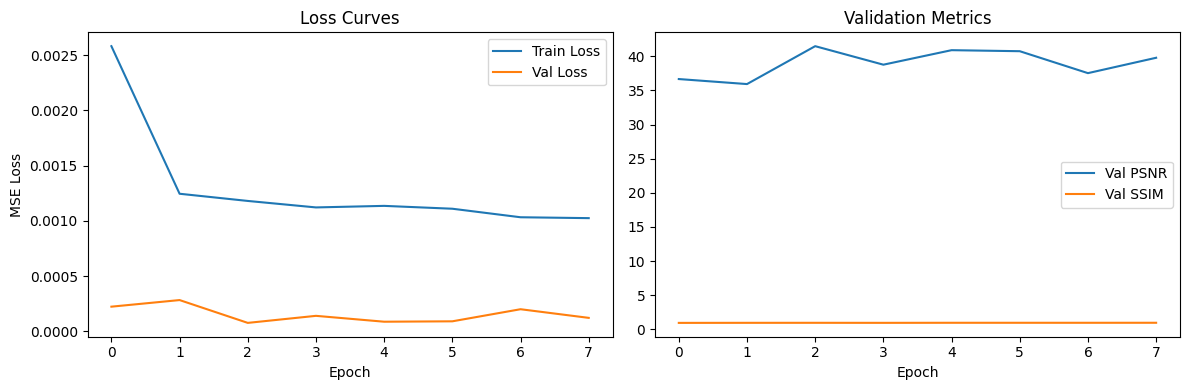

Best PSNR achieved: 41.47 dB (model saved as best_model.pt)


In [84]:
import os, glob
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from skimage.metrics import structural_similarity as compare_ssim
import matplotlib.pyplot as plt

# ----- Configuration -----
data_pattern   = "OpenFWI/FlatVelA/model/model*.npy"
batch_size     = 16
epochs         = 30
learning_rate  = 1e-3
weight_decay   = 1e-5            # small weight decay
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# ----- Load and Prepare Data (unchanged) -----
files = sorted(glob.glob(data_pattern))
if not files:
    raise FileNotFoundError(f"No files found matching {data_pattern}")
data_arrays = []
for f in files:
    arr = np.load(f).astype(np.float32)
    if arr.ndim == 3:        arr = arr[:, None, ...]
    elif arr.ndim == 4 and arr.shape[1] != 1:
        arr = arr.reshape(-1,1,arr.shape[2],arr.shape[3])
    data_arrays.append(arr)
X = np.concatenate(data_arrays, 0)
print(f"Loaded data shape: {X.shape}")
X_min, X_max = X.min(), X.max()
X = (X - X_min)/(X_max - X_min) if X_max>X_min else np.zeros_like(X)
X_tensor = torch.from_numpy(X)

dataset_size = X_tensor.shape[0]
val_count = max(1, int(0.1*dataset_size))
train_count = dataset_size - val_count
gen = torch.Generator().manual_seed(0)
train_idx, val_idx = torch.utils.data.random_split(range(dataset_size), [train_count,val_count], generator=gen)
train_idx, val_idx = list(train_idx), list(val_idx)

# ----- Dataset with stronger noise -----
class VelocityDataset(Dataset):
    def __init__(self, data, idxs, train_mode=True):
        self.data = data; self.idxs = idxs; self.train = train_mode
        self.max_noise_std  = 0.2   # up to 20% noise
        self.max_noise_mean = 0.05
        if not train_mode:
            rng = np.random.RandomState(42)
            self.fixed = {i: rng.normal(0, 0.05, size=self.data[i].shape).astype(np.float32)
                          for i in idxs}
    def __len__(self): return len(self.idxs)
    def __getitem__(self, i):
        idx = self.idxs[i]; clean = self.data[idx]
        if self.train:
            std  = torch.rand(1).item()*self.max_noise_std
            mean = (torch.rand(1).item()*2-1)*self.max_noise_mean
            noise = torch.randn_like(clean)*std + mean
        else:
            noise = torch.from_numpy(self.fixed[idx])
        noisy = torch.clamp(clean + noise, 0., 1.)
        return noisy, clean

train_ds = VelocityDataset(X_tensor, train_idx, train_mode=True)
val_ds   = VelocityDataset(X_tensor, val_idx,   train_mode=False)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)

# ----- U-Net definition (unchanged) -----
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = self.conv_block(1, 32)
        self.enc2 = self.conv_block(32,64)
        self.enc3 = self.conv_block(64,128)
        self.enc4 = self.conv_block(128,256)
        self.pool = nn.MaxPool2d(2,2)
        self.up3  = nn.ConvTranspose2d(256,128,2,2)
        self.dec3 = self.conv_block(256,128)
        self.up2  = nn.ConvTranspose2d(128,64,2,2)
        self.dec2 = self.conv_block(128,64)
        self.up1  = nn.ConvTranspose2d(64,32,2,2)
        self.dec1 = self.conv_block(64,32)
        self.conv_final = nn.Conv2d(32,1,1)
    def conv_block(self,in_c,out_c):
        return nn.Sequential(
            nn.Conv2d(in_c,out_c,3,padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(out_c,out_c,3,padding=1), nn.ReLU(inplace=True),
        )
    def forward(self,x):
        # pad to multiple of 8
        ph = (8 - x.shape[2]%8)%8; pw = (8 - x.shape[3]%8)%8
        x = F.pad(x,(0,pw,0,ph))
        x1 = self.enc1(x)
        x2 = self.enc2(self.pool(x1))
        x3 = self.enc3(self.pool(x2))
        x4 = self.enc4(self.pool(x3))
        u3 = self.dec3(torch.cat([self.up3(x4), x3],1))
        u2 = self.dec2(torch.cat([self.up2(u3), x2],1))
        u1 = self.dec1(torch.cat([self.up1(u2), x1],1))
        out = self.conv_final(u1)
        return out[..., :out.shape[-2]-ph, :out.shape[-1]-pw]

model = UNet().to(device)

# ----- Optimizer, Scheduler, Criterion -----
optimizer = torch.optim.Adam(model.parameters(),
                             lr=learning_rate,
                             weight_decay=weight_decay)
scheduler  = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2, verbose=True)
criterion  = nn.MSELoss()

# ----- Training with Early Stopping & Checkpointing -----
best_psnr   = 0.0
epochs_no_improve = 0
patience = 5

history = {"train_loss":[], "val_loss":[], "val_psnr":[], "val_ssim":[]}

for ep in range(1, epochs+1):
    # -- train --
    model.train()
    running_loss = 0.0
    for noisy, clean in train_loader:
        noisy, clean = noisy.to(device), clean.to(device)
        pred = model(noisy)
        loss = criterion(pred, clean)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        running_loss += loss.item()*noisy.size(0)
    train_loss = running_loss / train_count

    # -- validate --
    model.eval()
    val_loss, psnrs, ssims = 0.0, [], []
    with torch.no_grad():
        for noisy, clean in val_loader:
            noisy, clean = noisy.to(device), clean.to(device)
            pred = model(noisy)
            val_loss += criterion(pred,clean).item()*noisy.size(0)
            p_cpu = pred.cpu().numpy(); c_cpu = clean.cpu().numpy(); n_cpu = noisy.cpu().numpy()
            for i in range(p_cpu.shape[0]):
                pi = p_cpu[i,0]; ci = c_cpu[i,0]; ni = n_cpu[i,0]
                mse_pred = np.mean((pi-ci)**2)
                psnrs.append(float('inf') if mse_pred<1e-10 else 10*np.log10(1.0/mse_pred))
                ssims.append(compare_ssim(pi,ci,data_range=1.0))
    val_loss /= val_count
    val_psnr = np.mean(psnrs); val_ssim = np.mean(ssims)

    # -- logging & scheduling --
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_psnr"].append(val_psnr)
    history["val_ssim"].append(val_ssim)
    scheduler.step(val_loss)

    print(f"Epoch {ep:02d} → TrainLoss={train_loss:.4f}, ValLoss={val_loss:.4f}, "
          f"ValPSNR={val_psnr:.2f} dB, ValSSIM={val_ssim:.3f}")

    # -- early stopping & checkpoint --
    if val_psnr > best_psnr:
        best_psnr = val_psnr
        torch.save(model.state_dict(), "best_model.pt")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"No improvement in PSNR for {patience} epochs → stopping early.")
            break

# ----- Plot Training Curves -----
plt.figure(figsize=(12,4))
# Loss
plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"],   label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("MSE Loss"); plt.legend(); plt.title("Loss Curves")
# PSNR & SSIM
plt.subplot(1,2,2)
plt.plot(history["val_psnr"], label="Val PSNR")
plt.plot(history["val_ssim"], label="Val SSIM")
plt.xlabel("Epoch"); plt.title("Validation Metrics")
plt.legend(); plt.tight_layout()
plt.show()

print(f"Best PSNR achieved: {best_psnr:.2f} dB (model saved as best_model.pt)")

        Method        MSE     PSNR    SSIM
0  CNN (U-Net)   946.6619  40.6508  0.9756
1          PCA  1833.2147  38.2726  0.9383
2    Band Avg.   767.3058  43.8715  0.9902


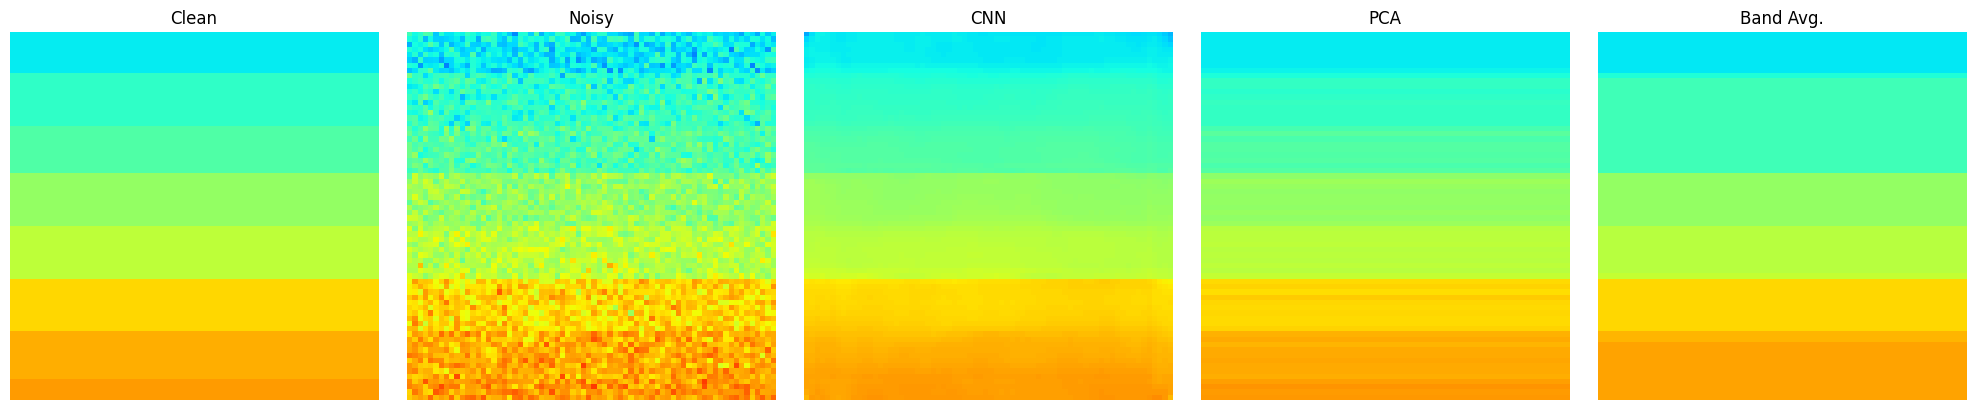

In [ ]:
# Evaluate and compare denoising methods on the validation set
np.random.seed(0)  # ensure reproducible noise across methods
full_data = X_tensor.numpy().astype(np.float32)

# Pre-allocate lists for metrics
mse_cnn, psnr_cnn, ssim_cnn = [], [], []
mse_pca, psnr_pca, ssim_pca = [], [], []
mse_band, psnr_band, ssim_band = [], [], []

for idx in val_idx:
    # Clean validation map (normalized)
    clean = full_data[idx, 0]
    # Add Gaussian noise (10% of dynamic range) to create a noisy input
    ns = 0.1 * (clean.max() - clean.min())
    noise = np.random.randn(*clean.shape).astype(np.float32) * ns
    noisy = np.clip(clean + noise, 0.0, 1.0).astype(np.float32)
    # --- CNN denoise ---
    inp = torch.from_numpy(noisy).unsqueeze(0).unsqueeze(0).to(device)  # 1×1×H×W, float32
    with torch.no_grad():
        out = model(inp).cpu().numpy()  # U-Net output (normalized)
    out_cnn = np.clip(out[0, 0], 0.0, 1.0)
    # --- PCA denoise ---
    flat = noisy.flatten()[None, :]
    rec = pca.inverse_transform(pca.transform(flat))
    out_pca = np.clip(rec.reshape(clean.shape), 0.0, 1.0)
    # --- Band-averaging denoise ---
    # --- Band‐averaging denoise (in original units) ---
    # 1) convert normalized noisy back to original
    noisy_orig = noisy * (X_max - X_min) + X_min
    # 2) compute matching orig‐scale noise std
    noise_std_orig = 0.1 * (noisy_orig.max() - noisy_orig.min())
    # 3) run band_denoising on original‐scale map
    _, denoised_orig, num_bands = band_denoising(noisy_orig, noise_std_orig)
    # 4) convert denoised back to normalized (for metric pipeline)
    out_band = (denoised_orig - X_min) / (X_max - X_min)
    # Denormalize to original scale for metric computation
    clean_orig    = clean    * (X_max - X_min) + X_min
    out_cnn_orig  = out_cnn  * (X_max - X_min) + X_min
    out_pca_orig  = out_pca  * (X_max - X_min) + X_min
    out_band_orig = out_band * (X_max - X_min) + X_min
    # Compute MSE, PSNR, SSIM metrics in original scale
    mse_c = np.mean((out_cnn_orig - clean_orig) ** 2)
    mse_p = np.mean((out_pca_orig - clean_orig) ** 2)
    mse_b = np.mean((out_band_orig - clean_orig) ** 2)
    ps_c = peak_signal_noise_ratio(clean_orig, out_cnn_orig, data_range=(X_max - X_min))
    ps_p = peak_signal_noise_ratio(clean_orig, out_pca_orig, data_range=(X_max - X_min))
    ps_b = peak_signal_noise_ratio(clean_orig, out_band_orig, data_range=(X_max - X_min))
    ss_c = structural_similarity(clean_orig, out_cnn_orig, data_range=(X_max - X_min))
    ss_p = structural_similarity(clean_orig, out_pca_orig, data_range=(X_max - X_min))
    ss_b = structural_similarity(clean_orig, out_band_orig, data_range=(X_max - X_min))
    # Accumulate metrics
    mse_cnn.append(mse_c);  psnr_cnn.append(ps_c);  ssim_cnn.append(ss_c)
    mse_pca.append(mse_p);  psnr_pca.append(ps_p);  ssim_pca.append(ss_p)
    mse_band.append(mse_b); psnr_band.append(ps_b); ssim_band.append(ss_b)

# Compute average metrics for the validation set
avg_mse_cnn  = np.mean(mse_cnn);   avg_psnr_cnn = np.mean(psnr_cnn);   avg_ssim_cnn = np.mean(ssim_cnn)
avg_mse_pca  = np.mean(mse_pca);   avg_psnr_pca = np.mean(psnr_pca);   avg_ssim_pca = np.mean(ssim_pca)
avg_mse_band = np.mean(mse_band);  avg_psnr_band = np.mean(psnr_band); avg_ssim_band = np.mean(ssim_band)

# Summary table of metrics
df = pd.DataFrame({
    "Method": ["CNN (U-Net)", "PCA", "Band Avg."],
    "MSE":   [avg_mse_cnn, avg_mse_pca, avg_mse_band],
    "PSNR":  [avg_psnr_cnn, avg_psnr_pca, avg_psnr_band],
    "SSIM":  [avg_ssim_cnn, avg_ssim_pca, avg_ssim_band]
})
df[["MSE", "PSNR", "SSIM"]] = df[["MSE", "PSNR", "SSIM"]].round(4)
print(df)

# Plot a representative validation example (clean, noisy, and denoised results)
ex = val_idx[0]
clean = full_data[ex, 0]
ns = 0.1 * (clean.max() - clean.min())
np.random.seed(0)  # use the same noise as above for consistency
noise = np.random.randn(*clean.shape).astype(np.float32) * ns
noisy = np.clip(clean + noise, 0.0, 1.0).astype(np.float32)
# Denoise using each method
inp = torch.from_numpy(noisy).unsqueeze(0).unsqueeze(0).to(device)
with torch.no_grad():
    cnn_out = model(inp).cpu().numpy()[0, 0]
pca_flat = noisy.flatten()[None, :]
pca_out = pca.inverse_transform(pca.transform(pca_flat)).reshape(clean.shape)
pca_out = np.clip(pca_out, 0.0, 1.0)
# --- Band‐averaging denoise (in original units) ---
# 1) convert normalized noisy back to original
noisy_orig = noisy * (X_max - X_min) + X_min
# 2) compute matching orig‐scale noise std
noise_std_orig = 0.1 * (noisy_orig.max() - noisy_orig.min())
# 3) run band_denoising on original‐scale map
_, denoised_orig, num_bands = band_denoising(noisy_orig, noise_std_orig)
# 4) convert denoised back to normalized (for metric pipeline)
band_out = (denoised_orig - X_min) / (X_max - X_min)

# Display the results
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for ax, img, title in zip(axs,
                          [clean, noisy, cnn_out, pca_out, band_out],
                          ["Clean", "Noisy", "CNN", "PCA", "Band Avg."]):
    im = ax.imshow(img, cmap="jet", vmin=0.0, vmax=1.0)
    ax.set_title(title)
    ax.axis("off")
plt.tight_layout()
plt.show()